# Electricity Data Forecasting Pipeline

**Team:** Rahul Gandhi, Vrinda, Lalith, Ojas Sharma, Sri Harsha Tuttaganti  
**Course:** DATA 608 – Developing Big Data Applications  

## 1. Introduction

This notebook presents the design and implementation of a comprehensive data engineering pipeline focused on analyzing and forecasting electricity data using data from the U.S. Energy Information Administration (EIA). The project is designed to automate the ingestion, processing, and visualization of electricity sales and generation data to support data-driven decision-making in the energy sector.

### Project Overview
The increasing complexity and volume of energy data have made it essential to develop automated, scalable, and cloud-native solutions for energy analytics. This project addresses that need by building a full-stack pipeline that:

- Ingests large-scale electricity data from the EIA

- Cleans, transforms, and stores the data in a structured format

- Forecasts future electricity-related metrics such as generation and revenue

- Visualizes trends and predictions through interactive dashboards using Streamlit

The pipeline supports robust forecasting models that enable more accurate planning and decision-making for energy providers and policymakers.

### Problem Definition

The energy sector faces growing challenges in handling the volume and complexity of public electricity data. Traditional systems often fall short in integrating high-frequency data streams, addressing data quality issues, and generating reliable forecasts in a timely manner. These limitations hinder efficient decision-making at both operational and policy levels.

This project aims to close this gap by developing a scalable, automated pipeline that not only processes raw electricity data but also produces actionable insights through intelligent forecasting and visualization.

### Objectives
- Automate the retrieval and ingestion of electricity data from the EIA

- Implement an end-to-end cloud-native data engineering solution

- Forecast key electricity metrics using time-series models

- Provide data-driven insights through an interactive web application


### ⚡ Importance of Electricity Forecasting
Electricity forecasting is crucial for multiple stakeholders:

- Government agencies use forecasts to monitor and regulate grid performance and sustainability goals.

- Energy providers leverage predictions to optimize energy production and minimize waste.

- Businesses and researchers rely on trends to study consumption patterns and support infrastructure planning.

Accurate forecasting also plays a central role in load balancing, helping to prevent blackouts and reduce strain on the electrical grid. Moreover, it contributes to cost efficiency by informing better pricing strategies and resource allocation.


### 🔗 Data Source
The U.S. Energy Information Administration (EIA) is a federal statistical agency within the Department of Energy. It collects, analyzes, and disseminates comprehensive data on a range of energy sources including coal, oil, natural gas, electricity, renewables, and nuclear energy. The data used in this project are sourced from the EIA’s publicly available repositories, ensuring credibility and relevance. All data is retrieved from the U.S. EIA (https://www.eia.gov/opendata/).


## 2. System Architecture

The architecture involves three core stages: Data Ingestion, Forecasting, and Visualization.

### 🔧 Technologies Used
- **AWS Services**: S3, Lambda, EC2, EventBridge
- **Forecasting**: Prophet (Meta's time-series library)
- **App Layer**: Streamlit for interactivity and dashboarding




### High-Level Architecture Diagram

Below is a high-level architecture diagram showing how the various components interact:

![System Architecture.jpeg](<attachment:System Architecture.jpeg>)

### Data Flow Explanation

1. **Data Ingestion**:
    - Python scripts hosted on EC2 use the EIA API to fetch retail sales and operational electricity data.
    - The `fetch_data()` function handles pagination, retries, and JSON transformation.

2. **Storage**:
    - Ingested CSV files are stored in AWS S3 buckets for both **historical** and **incremental** loads.
    - Lambda functions are triggered on new file uploads.

3. **Transformation & Processing**:
    - AWS Lambda cleans the data, removes nulls, and formats date columns.
    - Final output is written to DynamoDB for fast retrieval.

4. **Forecasting & Visualization**:
    - A Streamlit app deployed on EC2 reads cleaned data, applies Prophet models, and renders interactive dashboards.

---

### Technologies & Services Used

#### AWS

- **S3**: Object storage for raw and intermediate CSV files.
- **Lambda**: Serverless processing of uploaded files and transformation tasks.
- **EC2**: Hosting environment for Python scripts and the Streamlit dashboard.
- **DynamoDB**: Fast NoSQL storage for processed and filterable electricity data.

#### Prophet

- Used for univariate time series forecasting of revenue and electricity generation.
- Supports multiplicative seasonality and holiday effects.

#### Streamlit

- Lightweight web framework to build and deploy dashboards.
- Allows user interaction through dropdowns, sliders, and forecasting inputs.

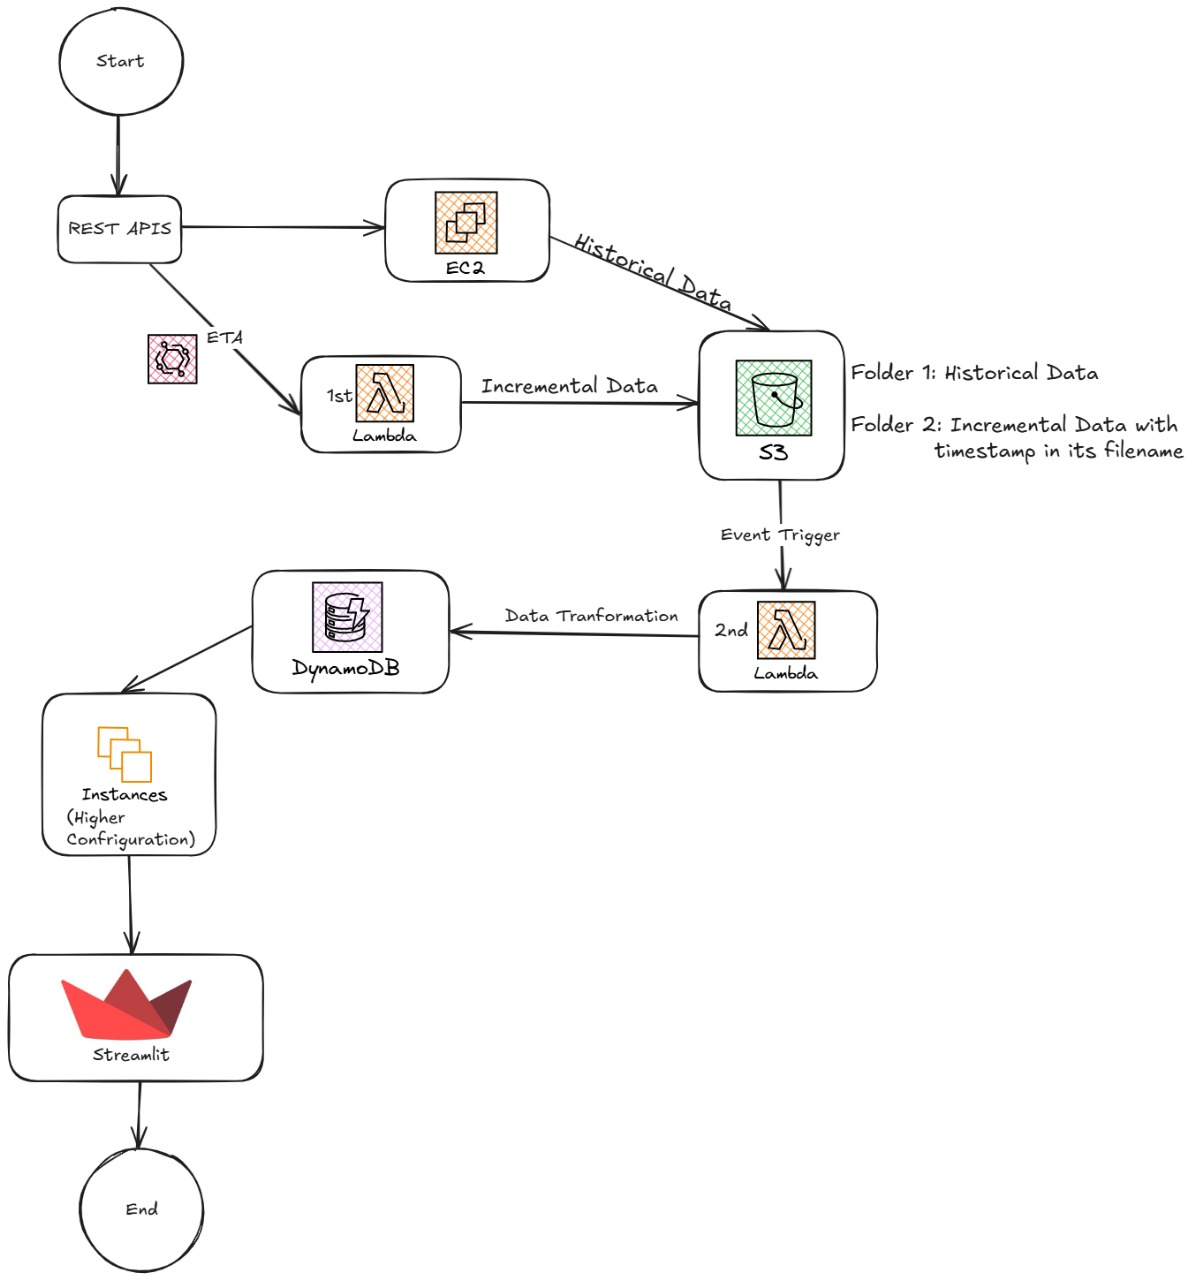

## 3. Environment Setup

### Python Packages Required
```bash
pip install pandas requests matplotlib seaborn streamlit prophet
```


### AWS Account Setup

To deploy the pipeline components, we used a standard AWS account with access to the following services:
- **Amazon S3** (for data storage)
- **AWS Lambda** (for serverless processing)
- **Amazon EC2** (for running scripts and Streamlit)
- **Amazon DynamoDB** (for final processed data)

### IAM Role & Permissions Configuration

We used IAM roles that comes with default permission.

### Required Python Packages & Virtual Environment Setup

On EC2 and locally, the following environment was used:

```bash
# Create and activate virtual environment
python3 -m venv venv
source venv/bin/activate

# Install required packages
pip install pandas requests boto3 prophet streamlit matplotlib seaborn


### 📁 Project Folder Structure
```bash
electricity-pipeline-project/
├── historical_data/
│   ├── extract_hist/
│   │   ├── fetch_daily_operational_historical.py
│   │   ├── fetch_monthy_operational_historical.py
│   │   └── fetch_sales_historical.py
│   ├── transform_lambda/
│   │   ├── transform_daily_operational_historical.py
│   │   ├── transform_monthly_operational_historical.py
│   │   └── transform_sales_historical.py
│   └── requirements.txt
├── lambda_functions/
│   ├── extract_incremental/
│   │   ├── daily_operational_inc.py
│   │   ├── monthly_operational_inc.py
│   │   └── monthly_sales_inc.py
│   ├── transform_load/
│   │   ├── transform_daily_operation_inc.py
│   │   ├── transform_monthly_operation_inc.py
│   │   └── transform_monthly_sale_inc.py
├── streamlit_app/
│   ├── app.py
│   └── requirements.txt
└── README.md
```

### GitHub Repository

[GitHub Repository – EIA Data Pipeline]https://github.com/rgandhi-ucalgary/eia-data-pipeline)


## 4. Data Collection

### API Access: EIA Registration & Key

- We signed up for a free API key from the U.S. Energy Information Administration (EIA).
- Base API portal: [https://www.eia.gov/opendata/](https://www.eia.gov/opendata/)
- API key was securely passed as a parameter in headers during each request.

### List of API Endpoints Used

#### Retail Sales Data (Monthly)
- Provides monthly data for:
  - Number of customers
  - Price (cents/kWh)
  - Revenue (thousands of dollars)
  - Sales (thousand MWh)

#### Operational Data (Monthly)
- Includes:
  - Generation by fuel type
  - Cost per BTU
  - Stocks, sulfur & ash content

#### Daily Region Data

- High-frequency generation data across regional grids (daily granularity)


### Script/Code to Pull Data

We created a generic ingestion function that paginates through EIA API data using offsets:



In [ ]:
import requests
import json
import pandas as pd
import time
from datetime import datetime
import yaml
import boto3
from botocore.exceptions import ClientError

def load_config():
    try:
        with open("../config.yaml", "r") as f:
            return yaml.safe_load(f)
    except FileNotFoundError:
        raise Exception("config.yaml file not found!")
    except yaml.YAMLError as e:
        raise Exception(f"Error parsing config.yaml: {e}")

config = load_config()

API_KEY = config['eia']['api_key']


def fetch_data(url, api_key, headers, max_rows=5000):
    offset = 0
    all_data = []
    attempts = 0
    max_attempts = 3

    while True:
        headers["X-Params"] = json.dumps({
            **json.loads(headers["X-Params"]),
            "offset": offset
        })
        
        try:
            response = requests.get(url, headers=headers, params={"api_key": api_key}, timeout=30)
            if response.status_code == 200:
                data = response.json().get("response", {}).get("data", [])
                if not data:
                    print(f"No more data after offset {offset}")
                    break
                
                all_data.extend(data)
                offset += max_rows
                print(f"Retrieved {len(data)} rows, Total: {len(all_data)} rows")
                time.sleep(2)  # API rate limit handling
            else:
                print(f"API Error {response.status_code}: {response.text}")
                break
        except requests.exceptions.Timeout:
            print(f"Request timeout at offset {offset}. Retrying in 5 seconds...")
            time.sleep(5)
            attempts += 1
            if attempts >= max_attempts:
                print("Max retry attempts reached")
                break
        except Exception as e:
            print(f"Unexpected error: {e}")
            break
    
    return pd.DataFrame(all_data)



### 📊 Retail Sales Data

This dataset includes monthly revenue, price, sales, and customer counts across different states and sectors.


In [ ]:
# Sales Data API Call
# Calculate previous 3 years
current_year = datetime.now().year
years_to_fetch = [current_year - i for i in range(1, 4)]


# API configuration
api_sales = "https://api.eia.gov/v2/electricity/retail-sales/data/"
base_params = {
    "frequency": "monthly",
    "data": ["customers", "price", "revenue", "sales"],
    "facets": {},
    "sort": [{"column": "period", "direction": "asc"}],
    "offset": 0,
    "length": 5000
}

for year in years_to_fetch:
    year_params = base_params.copy()
    year_params.update({
        "start": f"{year}-01",
        "end": f"{year}-01"
    })
    
    headers = {"X-Params": json.dumps(year_params)}
    
    sales_df = fetch_data(api_sales, API_KEY, year_params)
    
    # Data type conversion
    sales_df['period'] = pd.to_datetime(sales_df['period'])
    numeric_cols = ['customers', 'price', 'revenue', 'sales']
    sales_df[numeric_cols] = sales_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # CSV file paths
    local_path = f'historical_sales_{year}.csv'
    s3_path = f'historical/sales_{year}.csv'
    
    # Save as CSV
    sales_df.to_csv(
        local_path,
        index=False
    )


def load_config():
    try:
        with open("../config.yaml", "r") as f:
            return yaml.safe_load(f)
    except FileNotFoundError:
        raise Exception("config.yaml file not found!")
    except yaml.YAMLError as e:
        raise Exception(f"Error parsing config.yaml: {e}")
    
config = load_config()

API_KEY = config['eia']['api_key']

def upload_to_s3(file_path, s3_path):
    s3 = boto3.client('s3')
    
    try:
        s3.upload_file(file_path, config['aws']['s3_bucket'], s3_path)
        print(f"Uploaded {file_path} to s3://{config['aws']['s3_bucket']}/{s3_path}")
    except ClientError as e:
        print(f"S3 Upload Error: {e}")
        raise

    # Upload to S3 (assuming upload_to_s3 handles CSV)
    upload_to_s3(local_path, s3_path)


#### Data Schema

This dataset provides a comprehensive overview of **electricity sales** to ultimate customers, sourced from an API dashboard. It captures key electricity consumption metrics across different U.S. states, customer sectors, and time periods. These insights help understand **energy usage patterns** and **financial flows** within the electricity market.

##### Column Descriptions

- **period**: Reporting period (`YYYY-MM`)
- **stateid**: U.S. state abbreviation (e.g., `AL` for Alabama, `US` for national total)
- **stateDescription**: Full state name
- **sectorid**: Sector code (e.g., `RES` for Residential, `COM` for Commercial)
- **sectorName**: Full sector description (e.g., Residential, Industrial)
- **customers**: Number of electricity customers in the given sector and state
- **price**: Average price of electricity (in **cents per kilowatt-hour**)
- **revenue**: Total revenue from electricity sales (**in million dollars**)
- **sales**: Total electricity sold (**in million kilowatt-hours**)

######  Units Metadata

- **customers-units**: `"number of customers"`
- **price-units**: `"cents per kilowatt-hour"`
- **revenue-units**: `"million dollars"`
- **sales-units**: `"million kilowatt-hours"`

### Monthly Operational Data
This block pulls monthly generation and fuel consumption data from the Electric Power Operational API (starting 2023).

In [ ]:
# Calculate previous 3 years
current_year = datetime.now().year
years_to_fetch = [current_year - i for i in range(1, 4)]

# API configuration
api_ops_monthly = "https://api.eia.gov/v2/electricity/electric-power-operational-data/data/"
base_params = {
    "X-Params": json.dumps({
        "frequency": "monthly",
        "data": [
            "ash-content",
            "consumption-for-eg",
            "consumption-for-eg-btu",
            "consumption-uto",
            "consumption-uto-btu",
            "cost",
            "cost-per-btu",
            "generation",
            "heat-content",
            "receipts",
            "receipts-btu",
            "stocks",
            "sulfur-content",
            "total-consumption",
            "total-consumption-btu"
        ],
        "facets": {},
        "sort": [{"column": "period", "direction": "asc"}],
        "offset": 0,
        "length": 5000
    })
}



for year in years_to_fetch:
    year_params = base_params.copy()
    year_params.update({
        "start": f"{year}-01",
        "end": f"{year}-12"
    })
    
    headers = {"X-Params": json.dumps(year_params)}
    
    operational_monthly_df = fetch_data(api_ops_monthly, API_KEY, year_params)
    
    # Data type conversion
    operational_monthly_df['period'] = pd.to_datetime(operational_monthly_df['period'])
    numeric_cols = [
            "ash-content", "consumption-for-eg", "consumption-for-eg-btu",
            "consumption-uto", "consumption-uto-btu", "cost", "cost-per-btu",
            "generation", "heat-content", "receipts", "receipts-btu", "stocks",
            "sulfur-content", "total-consumption", "total-consumption-btu"
        ]
    operational_monthly_df[numeric_cols] = operational_monthly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # CSV file paths
    local_path = f'historical_monthly_operations_{year}.csv'
    s3_path = f'historical/monthly_operations_{year}.csv'
    
    # Save as CSV
    operational_monthly_df.to_csv(
        local_path,
        index=False
    )
    
    # Upload to S3 (assuming upload_to_s3 handles CSV)
    upload_to_s3(local_path, s3_path)

print("CSV data collection and upload complete!")

#### Data Schema

This dataset contains **monthly electricity operational data** for various fuel types and sectors across different U.S. states. It includes detailed information such as fuel consumption, cost, electricity generation, fuel receipts, stock levels, and content-related parameters (e.g., ash and sulfur content).

---

##### Columns Explanation

- **Period**: The reporting month and year (`YYYY-MM`)
- **Location**: Geographical area (e.g., state or "U.S. Total")
- **StateDescription**: Full name of the state or "U.S. Total"


###### Sector & Fuel Type
- **Sectorid**: Numeric sector identifier
- **SectorDescription**: Sector name (e.g., Electric Utility, All Sectors)
- **Fueltypeid**: Fuel type identifier (e.g., `FOS` for fossil fuels, `BIO` for biomass)
- **FuelTypeDescription**: Description of fuel type (e.g., fossil fuels, coal)


###### Fuel Content
- **ash-content**: Ash content in fuel (percentage)
- **ash-content-units**: Unit of ash content (usually `%`)
- **sulfur-content**: Sulfur content in fuel (percentage)
- **sulfur-content-units**: Unit of sulfur content (usually `%`)
- **heat-content**: Heat content of fuel
- **heat-content-units**: Units (e.g., Btu per physical units)

###### Consumption for Electricity Generation (EG)
- **consumption-for-eg**: Fuel consumed for electricity generation (physical units)
- **consumption-for-eg-units**: Units (e.g., thousand short tons, barrels)
- **consumption-for-eg-btu**: BTU equivalent of consumption
- **consumption-for-eg-btu-units**: Units (e.g., million MMBtu)

###### Consumption for Useful Thermal Output (UTO)
- **consumption-uto**: Fuel used for useful thermal output
- **consumption-uto-units**: Units for UTO consumption
- **consumption-uto-btu**: BTU equivalent of UTO consumption
- **consumption-uto-btu-units**: Units for UTO BTU

###### Cost Data
- **Cost**: Cost per fuel unit
- **cost-units**: Currency per unit (e.g., dollars per short ton)
- **cost-per-btu**: Cost per BTU
- **cost-per-btu-units**: Units (e.g., dollars per million Btu)

###### Electricity Generation
- **generation**: Electricity generated
- **generation-units**: Units (e.g., thousand megawatt-hours)

###### Fuel Receipts & Stocks
- **receipts**: Fuel received (physical units)
- **receipts-units**: Units for receipts
- **receipts-btu**: BTU equivalent of fuel receipts
- **receipts-btu-units**: Units for BTU
- **stocks**: Fuel stock levels
- **stocks-units**: Units for stocks

###### Total Consumption
- **total-consumption**: Total fuel consumption (physical units)
- **total-consumption-units**: Units for total consumption
- **total-consumption-btu**: Total BTU consumption
- **total-consumption-btu-units**: Units for total BTU


### Operational Data (Daily)

Daily regional electricity generation values for forecasting fine-grained trends.

In [ ]:
# Electric Power Operations API Call - daily
# Calculate previous 3 years
current_year = datetime.now().year
years_to_fetch = [current_year - i for i in range(0, 4)]

# API configuration

api_ops_daily = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"

base_params={
"X-Params":json.dumps({
    "frequency": "daily",
    "data": ["value"],
    "facets": {},
    "sort": [
        {
            "column": "period",
            "direction": "asc"
        }
    ],
    "offset": 0,
    "length": 5000
})
}

for year in years_to_fetch:
    if year == current_year:
        year_params = base_params.copy()
        year_params.update({
            "start": f"{year}-01-01",
            "end": "None"
        })
    else:
        year_params = base_params.copy()
        year_params.update({
            "start": f"{year}-01-01",
            "end": f"{year}-12-31"
        })
    
    headers = {"X-Params": json.dumps(year_params)}
    
    operational_daily_df = fetch_data(api_ops_daily, API_KEY, year_params)
    
    # Data type conversion
    operational_daily_df['period'] = pd.to_datetime(operational_daily_df['period'])
    operational_daily_df['value'] = operational_daily_df['value'].apply(pd.to_numeric, errors='coerce')
    
    # CSV file paths
    local_path = f'historical_daily_operations_{year}.csv'
    s3_path = f'historical/daily_operations_{year}.csv'
    
    # Save as CSV
    operational_daily_df.to_csv(
        local_path,
        index=False
    )
    
    # Upload to S3 (assuming upload_to_s3 handles CSV)
    upload_to_s3(local_path, s3_path)

print("CSV data collection and upload complete!")


#### Data Schema

This dataset, sourced from the **U.S. Energy Information Administration (EIA)**, provides **daily electricity generation data** categorized by **balancing authority** and **energy source**. It enables analysis of regional electricity supply and demand patterns and includes various energy types such as coal, natural gas, wind, and international sources.


##### Column Names and Descriptions

- **Period**: Date of electricity generation (`YYYY-MM-DD`)
- **Respondent**: Unique identifier for the reporting balancing authority or energy provider
- **Respondent-Name**: Full name of the balancing authority or provider (e.g., *Associated Electric Cooperative, Inc.*)
- **Fueltype**: Fuel code used for electricity generation (e.g., `COL` for coal, `NG` for natural gas, `WND` for wind)
- **Type-Name**: Full fuel type name (e.g., Coal, Natural Gas, Wind)
- **Timezone**: Time zone in which the generation is recorded (e.g., Central, Eastern)
- **Timezone-Description**: Duplicate or expanded description of the time zone
- **Value**: Amount of electricity generated
- **Value-Units**: Unit of measurement for generation value (**megawatt-hours – MWh**)


This dataset is especially useful for time series analysis, real-time energy monitoring, and forecasting electricity generation based on regional and fuel-type trends.


## 5. Data Storage (AWS S3)

### S3 Bucket Structure

We structured our storage into separate folders for full datasets and incremental updates.

```bash
📁 s3://eia-data-ucalgary/
├── retail_sales/
│   ├── historical/
│   └── incremental/
├── op_monthly/
│   ├── historical/
│   └── incremental/
├── op_daily/
│   ├── historical/
│   └── incremental/
```

#### Explanation
- `historical/`: stores all historical data retrieved through initial loads.
- `incremental/`: intended for future incremental ingestion jobs triggered by Lambda.

####  Format Justification

One of the key challenges faced during this project was related to using the Parquet file format within AWS Lambda functions. While Parquet is highly efficient for storing large-scale tabular data due to its columnar storage and compression capabilities, it introduces complications in serverless environments like AWS Lambda.

##### Issue: Lambda Layer Size Limit

- The libraries needed to read/write **Parquet** files (such as **PyArrow** or **fastparquet**) are large.
- These libraries **exceed AWS Lambda’s layer size limit of 250 MB (unzipped)**.
- As a result, deploying Lambda functions that process Parquet files directly becomes impractical.

##### Workaround / Current Approach

- Due to this limitation, we are exploring alternative strategies:
- Using **CSV** format for Lambda triggers 


## 6. Data Processing Pipeline

This section describes how we processed and transformed raw electricity data using a combination of **EC2**, **Lambda**, and **Python scripts**.

### EC2 Instance Setup for Initial Load

An Amazon EC2 instance was used to:

- Run initial one-time data ingestion scripts
- Install and run the Streamlit app locally for dashboard testing
- Perform local preprocessing and exploratory analysis

**Environment Setup Included**:
- Python 3.10 environment
- Required packages installed via `pip install -r requirements.txt`
- Files such as `fetch_daily_operational_historical.py`, `fetch_monthy_operational_historical.py`, etc. stored in local project directory

### Lambda Functions

To automate and scale processing tasks, two AWS Lambda functions were conceptualized:

#### 1. Data Fetch Lambda
- Scheduled using EventBridge to run weekly or monthly
- Calls the EIA API using the `fetch_data()` function
- Writes raw data into corresponding S3 folders (`incremental/`)

#### 2. Transformation Lambda
- Triggered automatically when a new file is uploaded to the S3 `incremental/` path
- Performs basic cleaning: type conversion, dropping invalid rows, timestamp formatting
- Writes processed data into:
  - DynamoDB (for Streamlit lookup)
  - Move increamental csv file from S3 bucket `incremental/` to `historical`

### EventBridge Trigger Setup

AWS EventBridge (CloudWatch Events) was used to schedule automated ingestion:
- Frequency: Weekly or Monthly
- Trigger: Lambda function for data collection from API
- Output: 
        - `retail_sales_YYYY-MM.csv`, etc. stored in S3 `incremental/`
        - `monthly_generation_YYYY-MM.csv`, etc. stored in S3 `incremental/`
        - `daily_generation_YYYY-MM-DD.csv`, etc. stored in S3 `incremental/`

### Handling Large Files and Optimization Techniques

The data volume fetched from the EIA API often exceeded 500,000 rows per dataset.

We handled this by:
- Using pagination (`offset`, `length`) inside the `fetch_data()` function
- Introducing `time.sleep(2)` to avoid hitting API rate limits
- Splitting daily and monthly data into separate processes
- Using `@st.cache_data` in Streamlit to avoid repeated I/O calls

#### Key Code Snippet (Pagination Logic)
```python
def fetch_data(url, api_key, headers, max_rows=5000):
    offset = 0
    all_data = []
    while True:
        headers["X-Params"] = json.dumps({
            **json.loads(headers["X-Params"]),
            "offset": offset
        })
        response = requests.get(url, headers=headers, params={"api_key": api_key}, timeout=30)
        if response.status_code == 200:
            data = response.json().get("response", {}).get("data", [])
            if not data:
                break
            all_data.extend(data)
            offset += max_rows
            time.sleep(2)
        else:
            break
    return pd.DataFrame(all_data)
```
---

## 7. Data Storage (DynamoDB)

Amazon DynamoDB was used as a **fast-access NoSQL database** to serve cleaned, query-ready electricity data for our Streamlit dashboard.

### Table Design & Schema

We created separate tables for storing enriched and filtered data required in the dashboard. The structure was designed to support rapid filtering by key attributes.

---

#### Table: `OperationalDailyData`
| Field Name           | Type    | Description                                                                 |
|----------------------|---------|-----------------------------------------------------------------------------|
| `respondent_date`    | String  |  A composite field combining reporting balancing authority and date when data is recorded        |
| `fueltype_timezone`  | String  | A composite field combining fuel type and its corresponding timezone        |
| `energy_generated_MWh` | Number  | The amount of energy generated, measured in megawatt-hours (MWh)            |
| `fueltype`           | String  | The type of fuel used (e.g., COL for coal, NG for natural gas)                |
| `respondent`         | String  | Unique identifier for the reporting balancing authority or provider         |
| `respondent_name`    | String  | The full name of the balancing authority or energy provider (e.g., Associated Electric Cooperative, Inc.) |
| `timestamp`          | String  | The date (YYYY-MM-DD) for the recorded data                             |    
| `timezone`           | String  | The time zone of the energy generation data (e.g., Central, Eastern)          |
| `value-units`        | String  | The unit of measurement for `energy_generated_MWh` (typically "MWh")          |

- **Partition Key**: `respondent_date` (String)
- **Sort Key**: `fueltype_timezone` (String)

---

#### Table: `OperationalMonthlyData`
| Field Name                | Type    | Description                                                                 |
|---------------------------|---------|-----------------------------------------------------------------------------|
| `state_month`             | String  | The state and month combined (e.g., California-2023-05) representing the reporting period |
| `sector_fuelType`         | String  | Composite key combining sector and fuel type                                |
| `ash-content`             | Number  | Ash content percentage in the consumed fuel                                 |
| `consumption_eg`          | Number  | Fuel consumption for electricity generation (physical units)                |
| `consumption_eg_btu`      | Number  | Fuel consumption for electricity generation in BTUs                         |
| `consumption_uto`         | Number  | Fuel consumption for useful thermal output (physical units)                   |
| `consumption_uto_btu`     | Number  | Fuel consumption for useful thermal output in BTUs                          |
| `cost`                    | Number  | Cost per fuel unit                                                          |
| `cost_per_btu`            | Number  | Cost per BTU calculated for the fuel                                        |
| `fuelType`                | String  | The fuel type descriptor (e.g., fossil fuels, biomass)                      |
| `fueltypeid`              | String  | Fuel type identifier                                                        |
| `generation`              | Number  | Electricity generated (e.g., in megawatt-hours)                             |
| `heat_content`            | Number  | Heat content of the consumed fuel                                           |
| `receipts`                | Number  | Amount of fuel received (physical units)                                    |
| `receipts-btu`            | Number  | Fuel receipts measured in BTUs                                              |
| `sector`                  | String  | The reporting sector (e.g., Residential, Commercial)                        |
| `state`                   | String  | The U.S. state name or abbreviation                                         |
| `stocks`                  | Number  | Fuel stock levels (physical units)                                          |
| `sulfur_content`          | Number  | Sulfur content percentage in the fuel                                       |
| `timestamp`               | String  | Timestamp for the data record                                               |
| `total_consumption`       | Number  | Total fuel consumption (physical units)                                     |
| `total_consumption_btu`   | Number  | Total fuel consumption in BTUs                                             |

- **Partition Key**: `state_month` (String)
- **Sort Key**: `sector_fuelType` (String)

---

#### Table: `SalesData`
| Field Name               | Type    | Description                                                                 |
|--------------------------|---------|-----------------------------------------------------------------------------|
| `state_sectorid`         | String  | A composite key combining state and sector ID (e.g., California_RES)                |
| `timestamp`              | String  | Timestamp for when the sales data was recorded                              |
| `num_customers`          | Number  | Number of customers in the sector                                         |
| `price_per_kwh`          | Number  | Average price of electricity (in cents per kilowatt-hour)                   |
| `revenue_per_customer`   | Number  | Revenue generated per customer (optional metric)                           |
| `sectorid`               | String  | Identifier for the customer sector (e.g., RES for Residential)               |
| `sectorName`             | String  | Full name of the customer sector (e.g., Residential, Commercial)             |
| `state`                  | String  | The state in which the sales occurred                                      |
| `total_revenue`          | Number  | Total revenue from electricity sales (in million dollars)                  |
| `total_sales`            | Number  | Total electricity sold (in million kilowatt-hours)                         |

- **Partition Key**: `state_sectorid` (String)
- **Sort Key**: `timestamp` (String)


## 8. Forecasting Module

We used **Prophet** (developed by Meta) as the forecasting engine. Prophet is known for handling seasonality, missing values, and outliers with ease.

### 🔍 Forecasting Workflow
1. Filter dataset based on state and sector/fuel
2. Rename columns to Prophet-compatible format: `ds` (datetime), `y` (value)
3. Fit the Prophet model
4. Predict future values based on selected horizon

### 🔧 Prophet Parameters
- `seasonality_mode = "multiplicative"` was chosen due to high variability in energy usage.
- `daily_seasonality = True` used for daily forecasts only.
- Forecast horizon:
  - 6 months for monthly data
  - 30 days for daily data

### 📘 Code Example
```python
from prophet import Prophet

df_prophet = f_s[['timestamp', 'total_revenue']].rename(columns={'timestamp': 'ds', 'total_revenue': 'y'})

model = Prophet(seasonality_mode="multiplicative")
model.fit(df_prophet)

future = model.make_future_dataframe(periods=forecast_horizon, freq='M')
forecast = model.predict(future)
st.subheader("Forecasted Revenue Data")
```

> 🔮 The forecasts are visualized interactively through Streamlit (see next section).


## 9. Visualization with Streamlit

We used **Streamlit**, a lightweight Python web app framework, to build an interactive dashboard that supports both **forecasting** and **exploratory data analysis (EDA)**.

The app enables:
- Real-time forecasting using Prophet
- Filterable views by state, sector, fuel, and time range
- Visual exploration of sales and generation trends

---

## Setting Up Streamlit

Streamlit was installed via pip:

```bash
pip install -r streamlit_app/requirements.txt
```
The dashboard was created in a single script:
📄 app.py

To run the app locally:
```
streamlit run app.py
```

## Dashboard Layout & Features

### 🧭 Sidebar: Navigation Panel

Users choose between two analysis modes:

- **Forecast**
- **EDA (Exploratory Data Analysis)**

---

### Forecast Mode

In **Forecast Mode**, users interactively select:

- **Dataset**:
  - Sales
  - Generation - Monthly
  - Generation - Daily

- **Filters Based on Dataset**:
  - `stateDescription`
  - `sectorName` or `sectorDescription`
  - `fuelTypeDescription` or `type-name`

- **Forecast Horizon**:
  - Defined by user input in months or days, depending on dataset

---

### EDA Mode

In **EDA Mode**, users explore predefined analytics including:

- 📊 **Top 5 revenue-generating states** (based on sales data)
- ⚡ **Top electricity-generating regions** (based on fuel and company)
- 📅 **Time series trends** for revenue or generation

Visuals are automatically updated based on top performers.

---

## Forecasting Section (Interactive)

Once the user configures selections and clicks **Run Forecast**, the app executes the following:

1. **Filters** the selected dataset using state, sector, and fuel type
2. **Prepares** the filtered data for Prophet by renaming columns:
   - `period` → `ds`
   - `revenue` / `generation` / `value` → `y`
3. **Fits** a Prophet model using the prepared data
4. **Generates** a future DataFrame for the forecast period
5. **Displays** the output forecast plot within the dashboard

The forecast visualization includes:
- Prediction curve (`yhat`)
- Confidence intervals (`yhat_lower`, `yhat_upper`)
- Historical trend overlay

> All outputs are rendered using Streamlit’s `st.pyplot()` for seamless integration.



**Code for Forecasting**

```python
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import boto3

# Function to scan all items from a DynamoDB table (with basic pagination)
def scan_table(table):
    data = []
    response = table.scan()
    data.extend(response.get('Items', []))
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        data.extend(response.get('Items', []))
    return data

@st.cache_data
def load_sales_data():
    # Connect to DynamoDB and select the sales table
    dynamodb = boto3.resource('dynamodb', region_name="us-east-1")
    table = dynamodb.Table('SalesData')
    data = scan_table(table)
    return pd.DataFrame(data)

@st.cache_data
def load_op_monthly_data():
    dynamodb = boto3.resource('dynamodb', region_name="us-east-1")
    table = dynamodb.Table('OperationalMonthlyData')
    data = scan_table(table)
    return pd.DataFrame(data)

@st.cache_data
def load_op_daily_data():
    dynamodb = boto3.resource('dynamodb', region_name="us-east-1")
    table = dynamodb.Table('OperationalDailyData')
    data = scan_table(table)
    return pd.DataFrame(data)

# Load the data from DynamoDB
sales = load_sales_data()
op_monthly = load_op_monthly_data()
op_daily = load_op_daily_data()

print("Data Loading Complete")

# Convert the timestamp columns (if present) to datetime objects

if 'timestamp' in sales.columns:
    sales['timestamp'] = pd.to_datetime(sales['timestamp'])
if 'timestamp' in op_monthly.columns:
    op_monthly['timestamp'] = pd.to_datetime(op_monthly['timestamp'])
if 'timestamp' in op_daily.columns:
    op_daily['timestamp'] = pd.to_datetime(op_daily['timestamp'], format="mixed", dayfirst=True)


print("Date Conversion Complete")

st.sidebar.title("Analysis Type")
analysis_type = st.sidebar.radio("Select an analysis type:", ["Forecast", "EDA"])

if analysis_type == "Forecast":
    st.sidebar.title("Select Dataset for Forecast")
    dataset = st.sidebar.radio("Choose a dataset:", ["Sales", "Generation - Monthly", "Generation - Daily"])

    if dataset == "Sales":
        st.title("State-wise Revenue Forecasting")
        col1, col2 = st.columns(2)
        with col1:
            states = sales["state"].unique()
            selected_state = st.selectbox("Select a State:", states)
        with col2:
            sector = sales["sectorName"].unique()
            selected_sector = st.selectbox("Select a Sector:", sector)

        forecast_horizon = st.number_input("Enter forecast horizon (months)", min_value=1, value=6, step=1)

        if st.button("Run Forecast", key="sales_forecast"):
            f_s = sales[(sales['state'] == selected_state) & (sales['sectorName'] == selected_sector)]
            if not f_s.empty:
                df_prophet = f_s[['timestamp', 'total_revenue']].rename(columns={'timestamp': 'ds', 'total_revenue': 'y'})
                model = Prophet(seasonality_mode="multiplicative")
                model.fit(df_prophet)
                future = model.make_future_dataframe(periods=forecast_horizon, freq='M')
                forecast = model.predict(future)
                st.subheader("Forecasted Revenue Data")
                fig, ax = plt.subplots(figsize=(10, 5))
                model.plot(forecast, ax=ax)
                plt.title(f"Sales Forecast for {selected_state} - {selected_sector} Sector")
                st.pyplot(fig)
            else:
                st.error(f"No data available for {selected_state} in the {selected_sector} sector.")

    elif dataset == "Generation - Monthly":
        st.title("Electricity Generation Forecasting - Monthly Data")
        col1, col2, col3 = st.columns(3)
        with col1:
            states = op_monthly["state"].unique()
            selected_state = st.selectbox("Select a State:", states)
        with col2:
            sector = op_monthly["sector"].unique()
            selected_sector = st.selectbox("Select a Sector:", sector)
        with col3:
            fuel = op_monthly["fuelType"].unique()
            selected_fuel = st.selectbox("Select a Fuel:", fuel)

        forecast_horizon = st.number_input("Enter forecast horizon (months)", min_value=1, value=6, step=1)

        if st.button("Run Forecast", key="monthly_forecast"):
            f_s = op_monthly[
                (op_monthly['state'] == selected_state) &
                (op_monthly['sector'] == selected_sector) &
                (op_monthly['fuelType'] == selected_fuel)
            ]
            if not f_s.empty:
                df_prophet = f_s[['timestamp', 'generation']].rename(columns={'timestamp': 'ds', 'generation': 'y'})
                model = Prophet(seasonality_mode="multiplicative")
                model.fit(df_prophet)
                future = model.make_future_dataframe(periods=forecast_horizon, freq='M')
                forecast = model.predict(future)
                st.subheader("Forecasted Generation Data")
                fig, ax = plt.subplots(figsize=(10, 5))
                model.plot(forecast, ax=ax)
                plt.title(f"Generation Forecast for {selected_state} - {selected_sector} Sector")
                st.pyplot(fig)
            else:
                st.error(f"No data available for {selected_state} in the {selected_sector} sector.")

    elif dataset == "Generation - Daily":
        st.title("Electricity Generation Forecasting - Daily Data")
        col1, col2, col3 = st.columns(3)
        with col1:
            states = op_daily["respondent_name"].unique()
            selected_state = st.selectbox("Select a State:", states)
        with col2:
            sector = op_daily["timezone"].unique()
            selected_sector = st.selectbox("Select a Sector:", sector)
        with col3:
            name = op_daily["fueltype"].unique()
            selected_name = st.selectbox("Select a Name:", name)

        forecast_horizon = st.number_input("Enter forecast horizon (days)", min_value=1, value=30, step=1)

        if st.button("Run Forecast", key="daily_forecast"):
            f_s = op_daily[
                (op_daily['respondent_name'] == selected_state) &
                (op_daily['timezone'] == selected_sector) &
                (op_daily['fueltype'] == selected_name)
            ]
            if not f_s.empty:
                df_prophet = f_s[['timestamp', 'energy_generated_MWh']].rename(columns={'timestamp': 'ds', 'energy_generated_MWh': 'y'})
                model = Prophet(seasonality_mode="multiplicative", daily_seasonality=True)
                model.fit(df_prophet)
                future = model.make_future_dataframe(periods=forecast_horizon, freq='D')
                forecast = model.predict(future)
                st.subheader("Forecasted Revenue Data")
                fig, ax = plt.subplots(figsize=(10, 5))
                model.plot(forecast, ax=ax)
                plt.title(f"Revenue Forecast for {selected_state} - {selected_sector} Sector")
                st.pyplot(fig)
            else:
                st.error(f"No data available for {selected_state} in the {selected_sector} sector.")


```

![Forecast - Daily Generation.jpeg](<attachment:Forecast - Daily Generation.jpeg>) 

![Forecast - Monthly Generation.jpeg](<attachment:Forecast - Monthly Generation.jpeg>) 

![Forecast - Monthly Revenue.jpeg](<attachment:Forecast - Monthly Revenue.jpeg>)
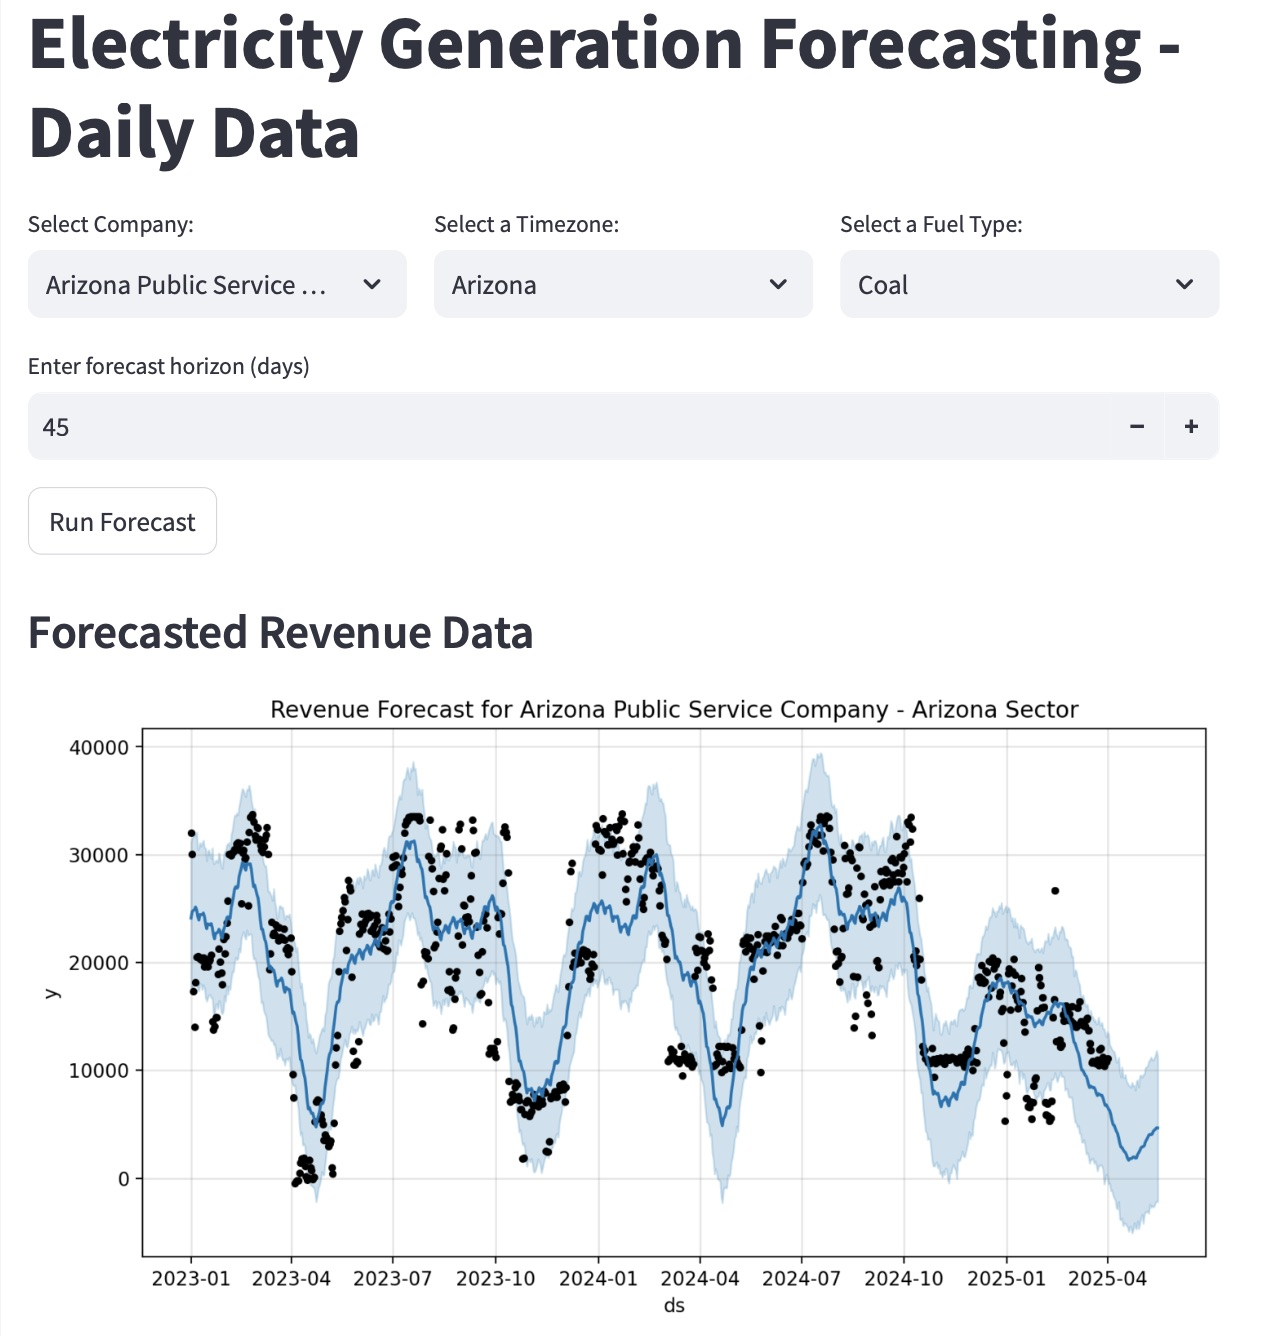
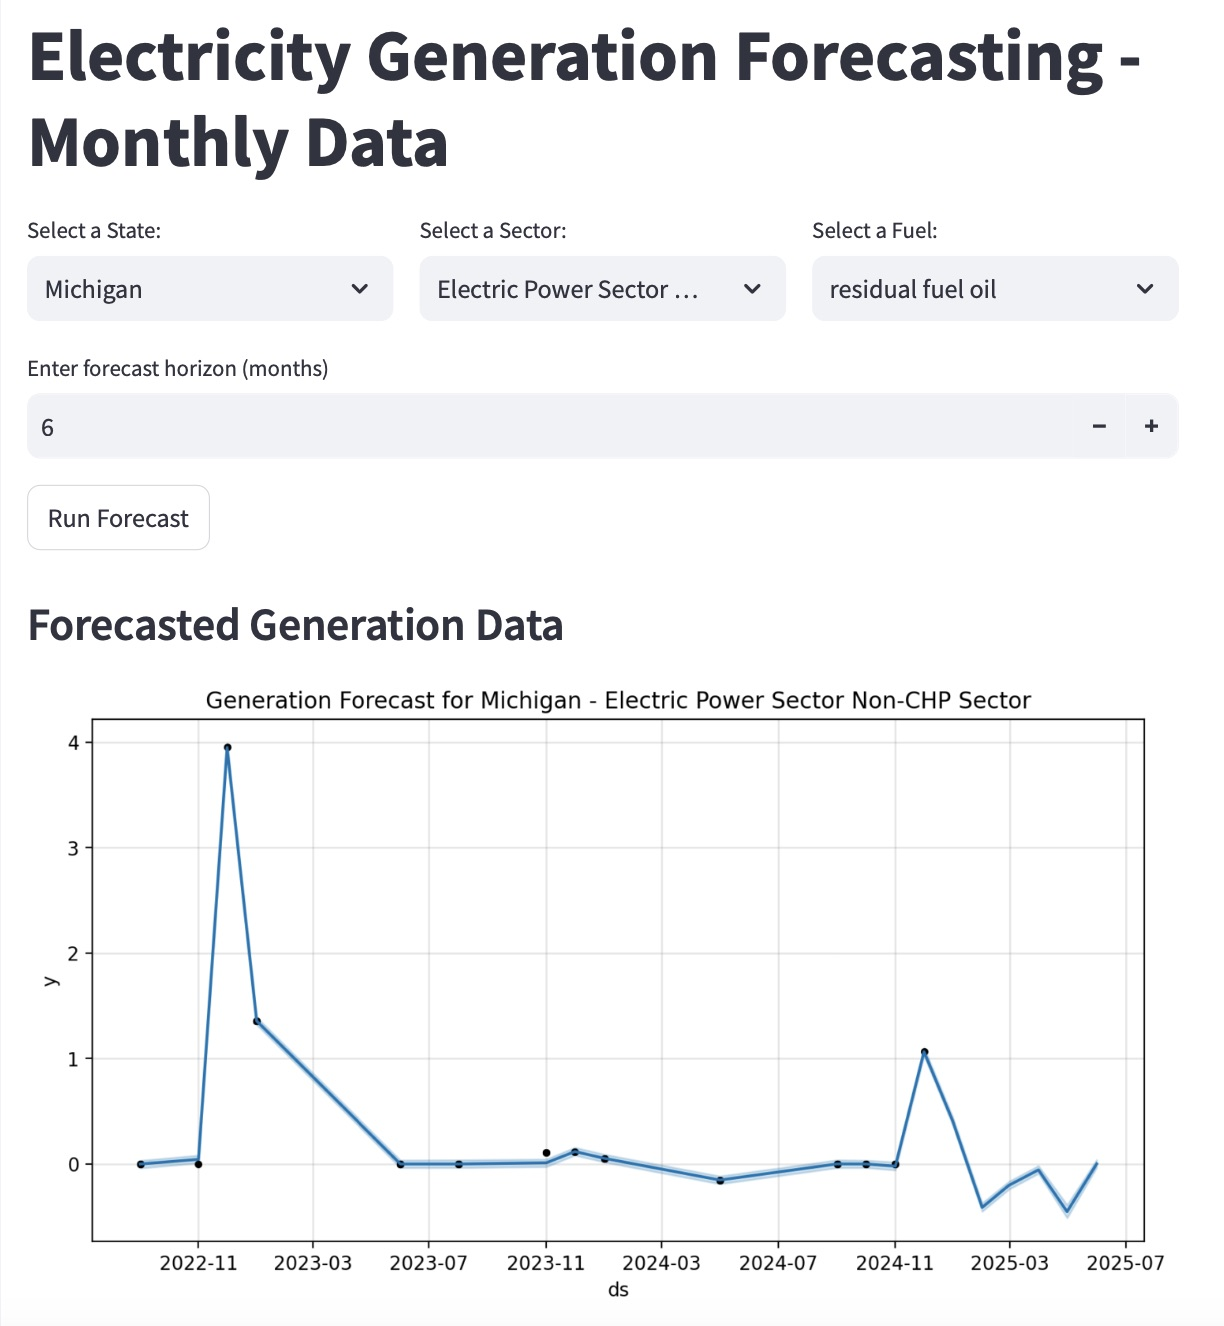
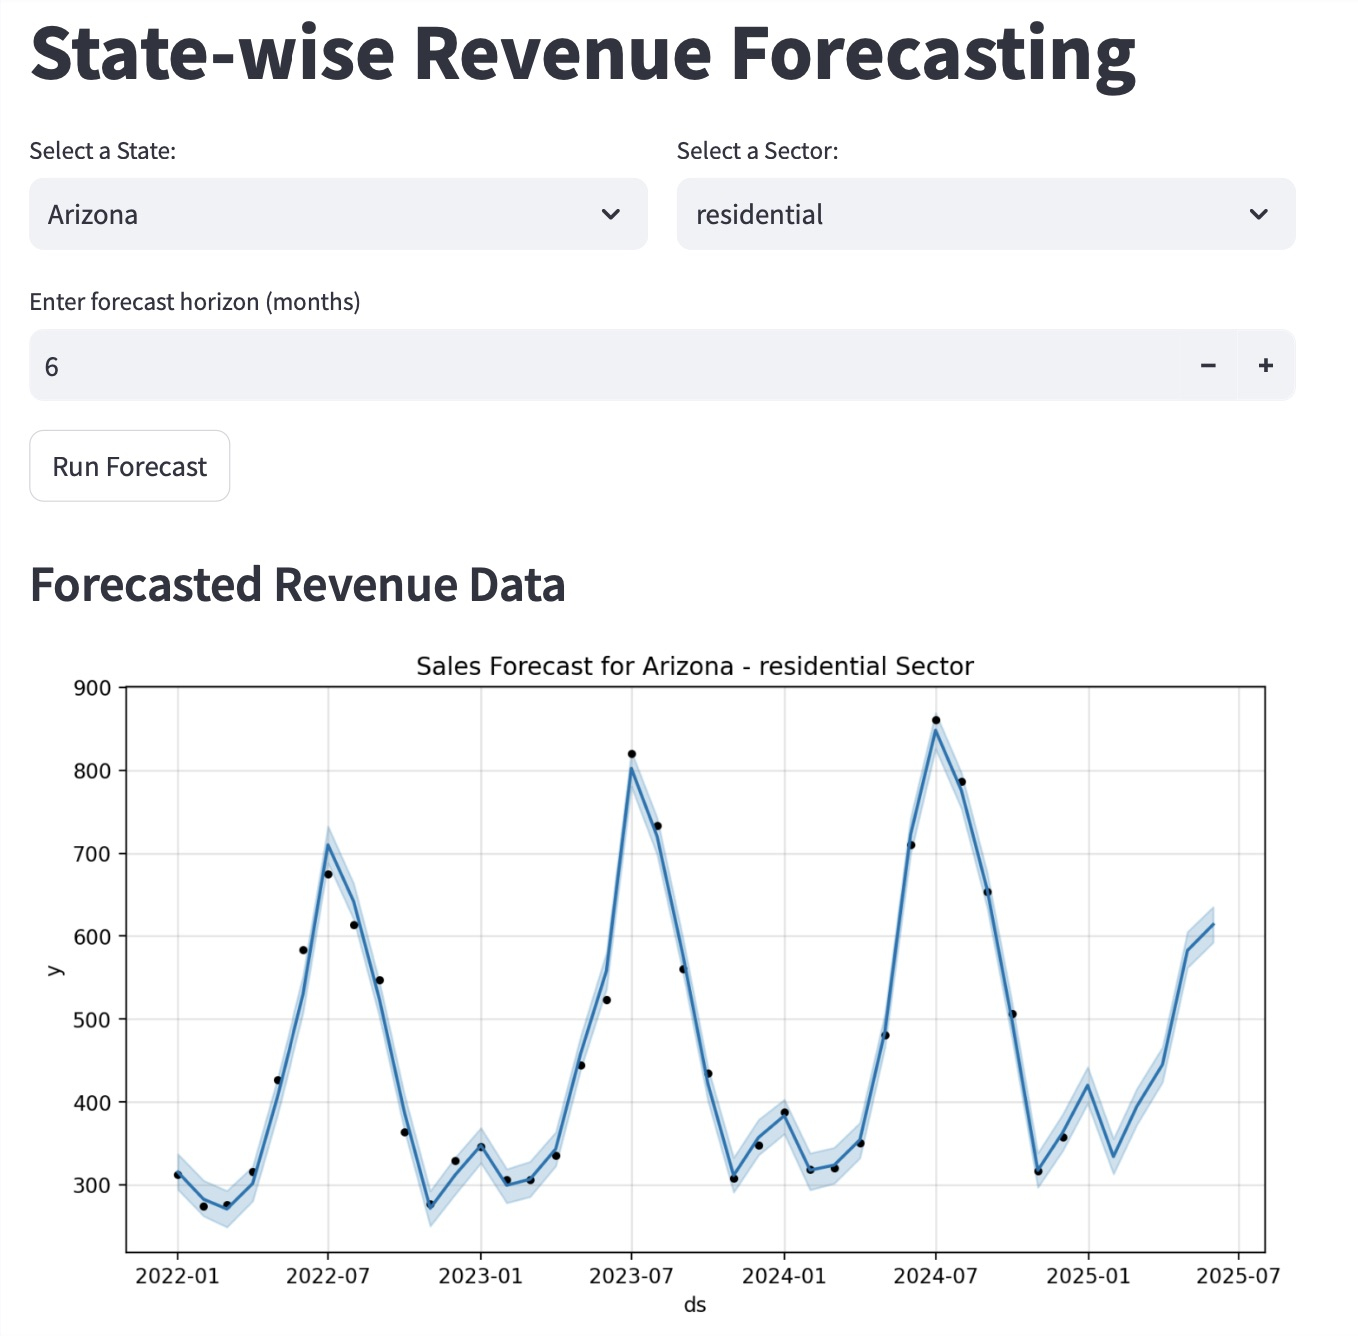

**Code for EDA**

```python
elif analysis_type == "EDA":
    st.sidebar.title("EDA Options")

    st.title("Exploratory Data Analysis")
    st.subheader("Revenue by Top 5 States (Sales Data)")
    sal = sales[sales['state'] != 'U.S. Total']
    top_5_states = sal.sort_values(by=['total_revenue'], ascending=False)['state'].unique()[:5]


    filtered_sales = sales[sales['state'].isin(top_5_states)]
    filtered_sales['timestamp'] = pd.to_datetime(filtered_sales['timestamp'])
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    sns.lineplot(
        data=filtered_sales,
        x="timestamp",
        y="total_revenue",
        hue="state",
        marker="o",
        linewidth=2.5,
        palette="tab20",
        ci=None
    )
    plt.title("Revenue by Top 5 States", fontsize=14, pad=20)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Revenue (million dollars)", fontsize=12)
    plt.xticks(
        pd.date_range(start='2023-01-01', end='2025-01-01', freq='YS'),
        labels=[str(year) for year in range(2023, 2026)],
        rotation=45
    )
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    st.pyplot(fig1)


    st.subheader("Electricity Generation by Top 5 Companies (Daily Data)")
    op_d = op_daily[op_daily['respondent_name'] != 'United States Lower 48']
    top_10_names = op_d[['respondent_name', 'energy_generated_MWh', 'timezone']]\
                     .sort_values(by=['energy_generated_MWh'], ascending=False)['respondent_name']\
                     .unique()[:5]

    filtered_names = op_daily[op_daily['respondent_name'].isin(top_10_names)]
    filtered_names['timestamp'] = pd.to_datetime(filtered_names['timestamp'])
    fig2, ax2 = plt.subplots(figsize=(16, 8))
    sns.lineplot(
        data=filtered_names,
        x="timestamp",
        y="energy_generated_MWh",
        hue="respondent_name",
        marker="o",
        linewidth=2.5,
        palette="tab20",
        ci=None
    )
    plt.title("Electricity Generation Value by Top 5 Companies", fontsize=14, pad=20)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Value (megawatthours)", fontsize=12)
    start_year = filtered_names['timestamp'].min().year
    end_year = filtered_names['timestamp'].max().year
    plt.xticks(
        pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='YS'),
        labels=[str(year) for year in range(start_year, end_year + 1)],
        rotation=45
    )
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(title="Respondent", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    st.pyplot(fig2)


    st.subheader("Electricity Generation by Top 5 States (Monthly Data)")
    op_m = op_monthly[op_monthly['state'] != 'U.S. Total']
    top_10_names = op_m[['state', 'generation', 'fuelType']]\
                     .sort_values(by=['generation'], ascending=False)['state']\
                     .unique()[:5]

    filtered_names = op_monthly[op_monthly['state'].isin(top_10_names)]
    filtered_names['timestamp'] = pd.to_datetime(filtered_names['timestamp'])
    fig3, ax3 = plt.subplots(figsize=(16, 8))
    sns.lineplot(
        data=filtered_names,
        x="timestamp",
        y="generation",
        hue="state",
        marker="o",
        linewidth=2.5,
        palette="tab20",
        ci=None
    )
    plt.title("Electricity Generation by Top 5 States", fontsize=14, pad=20)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Generation (thousand megawatthours)", fontsize=12)
    start_year = filtered_names['timestamp'].min().year
    end_year = filtered_names['timestamp'].max().year
    plt.xticks(
        pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='YS'),
        labels=[str(year) for year in range(start_year, end_year + 1)],
        rotation=45
    )
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    st.pyplot(fig3)

```


![EDA - Daily Generation.jpeg](<attachment:EDA - Daily Generation.jpeg>) 

![EDA - Monthly Generation.jpeg](<attachment:EDA - Monthly Generation.jpeg>) 

![EDA - Revenue.jpeg](<attachment:EDA - Revenue.jpeg>)
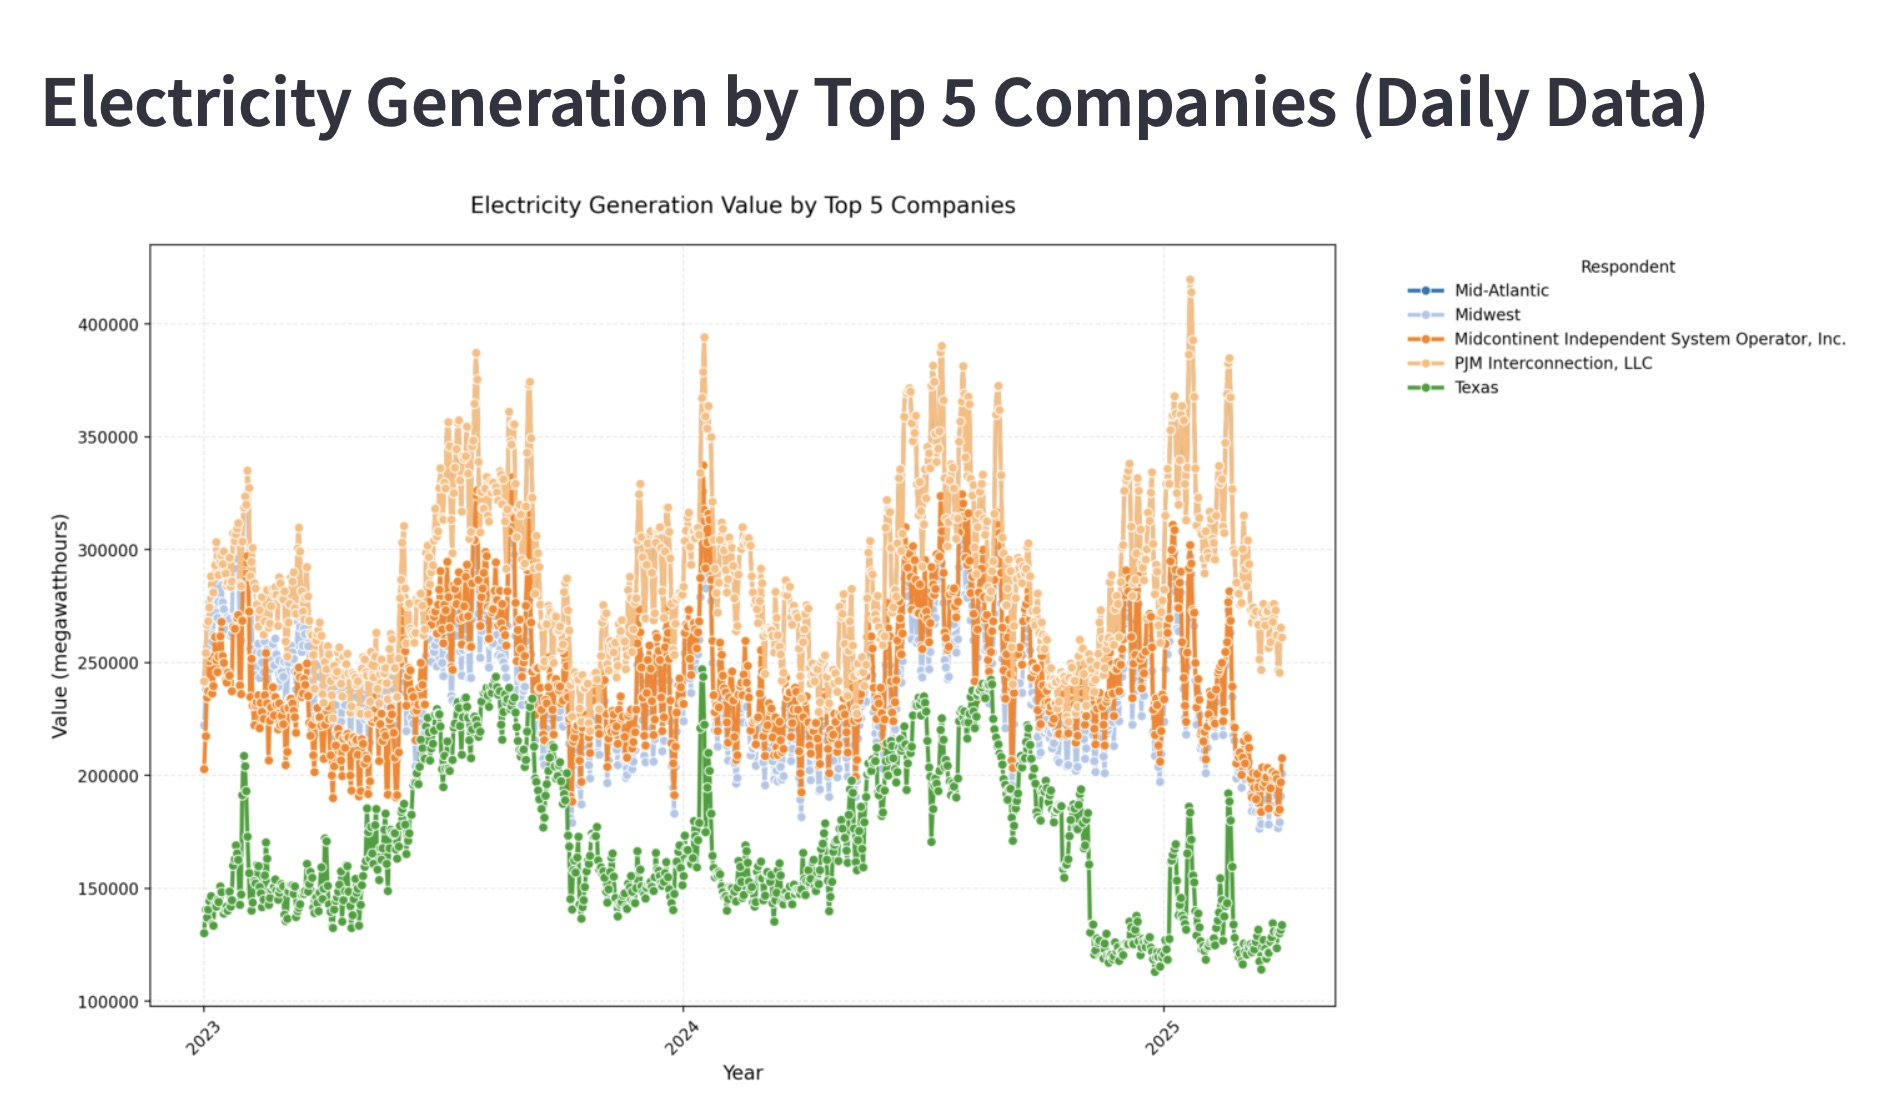
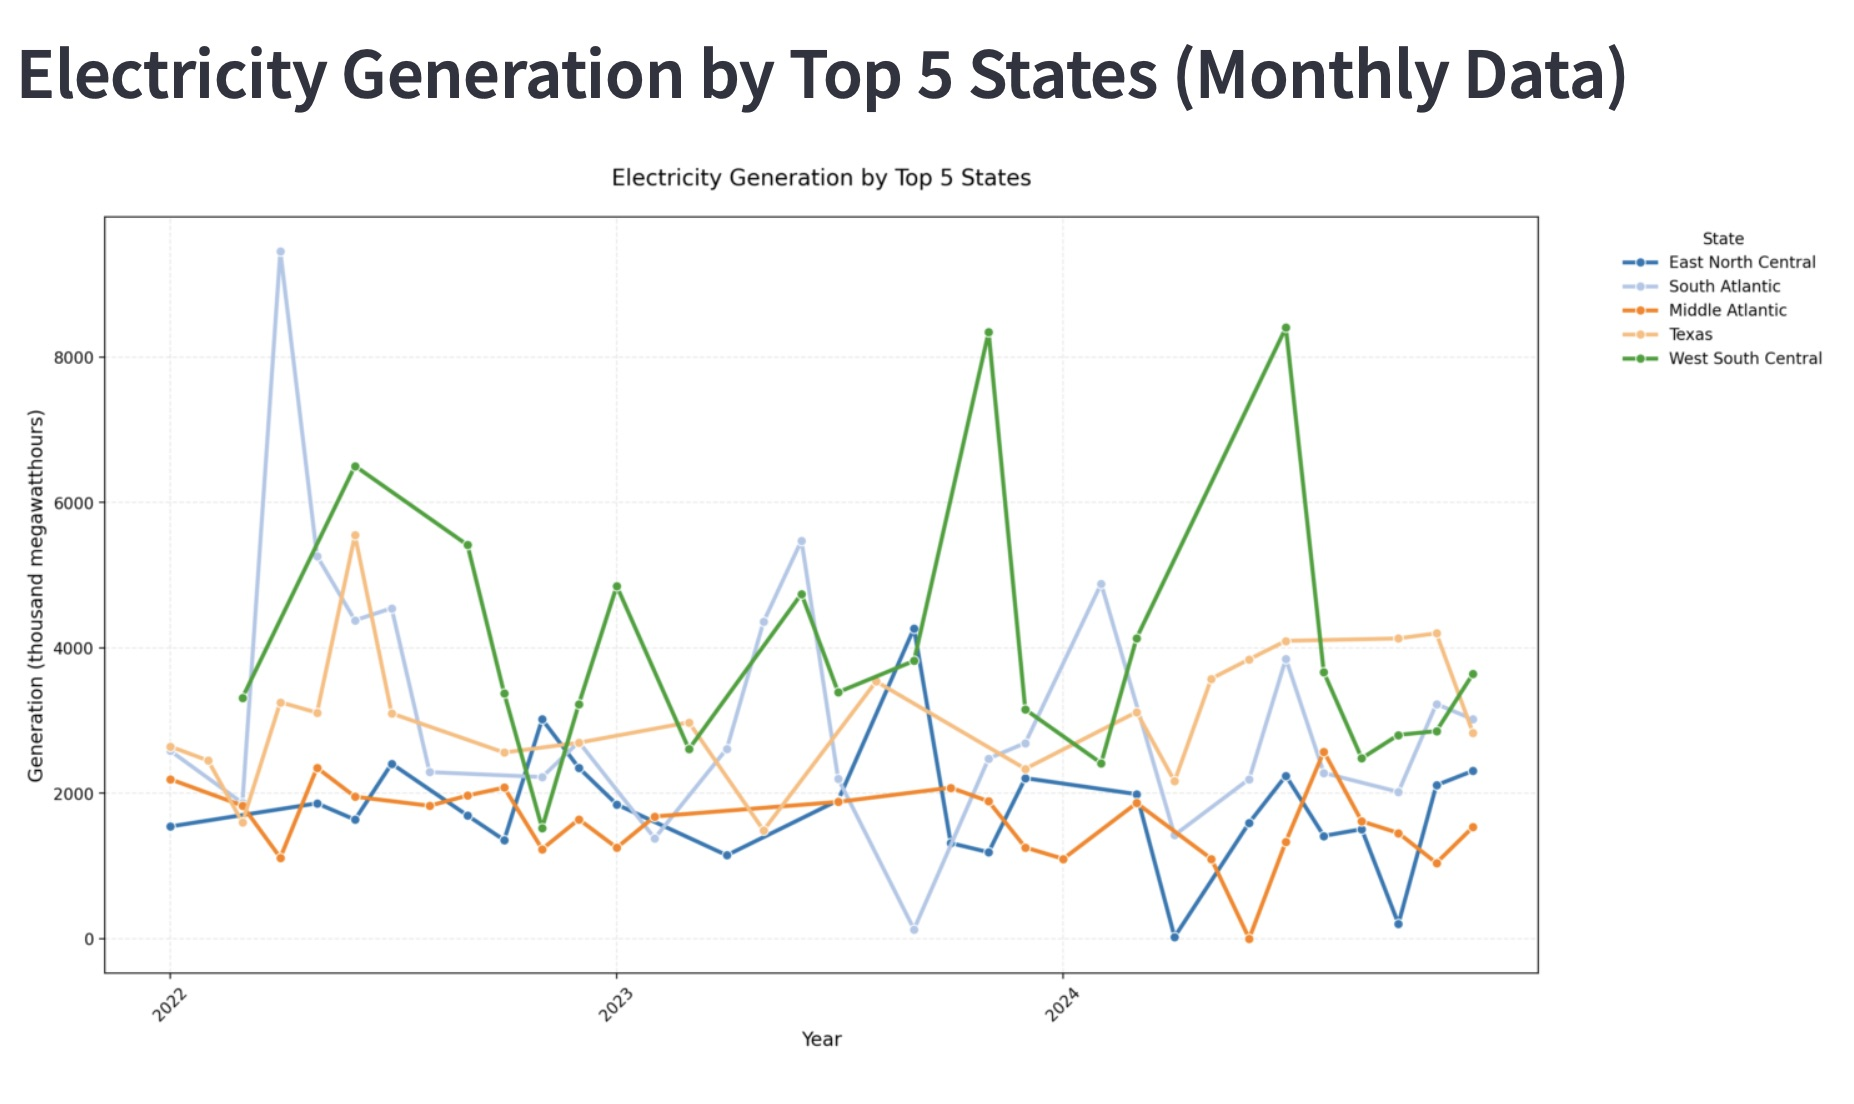
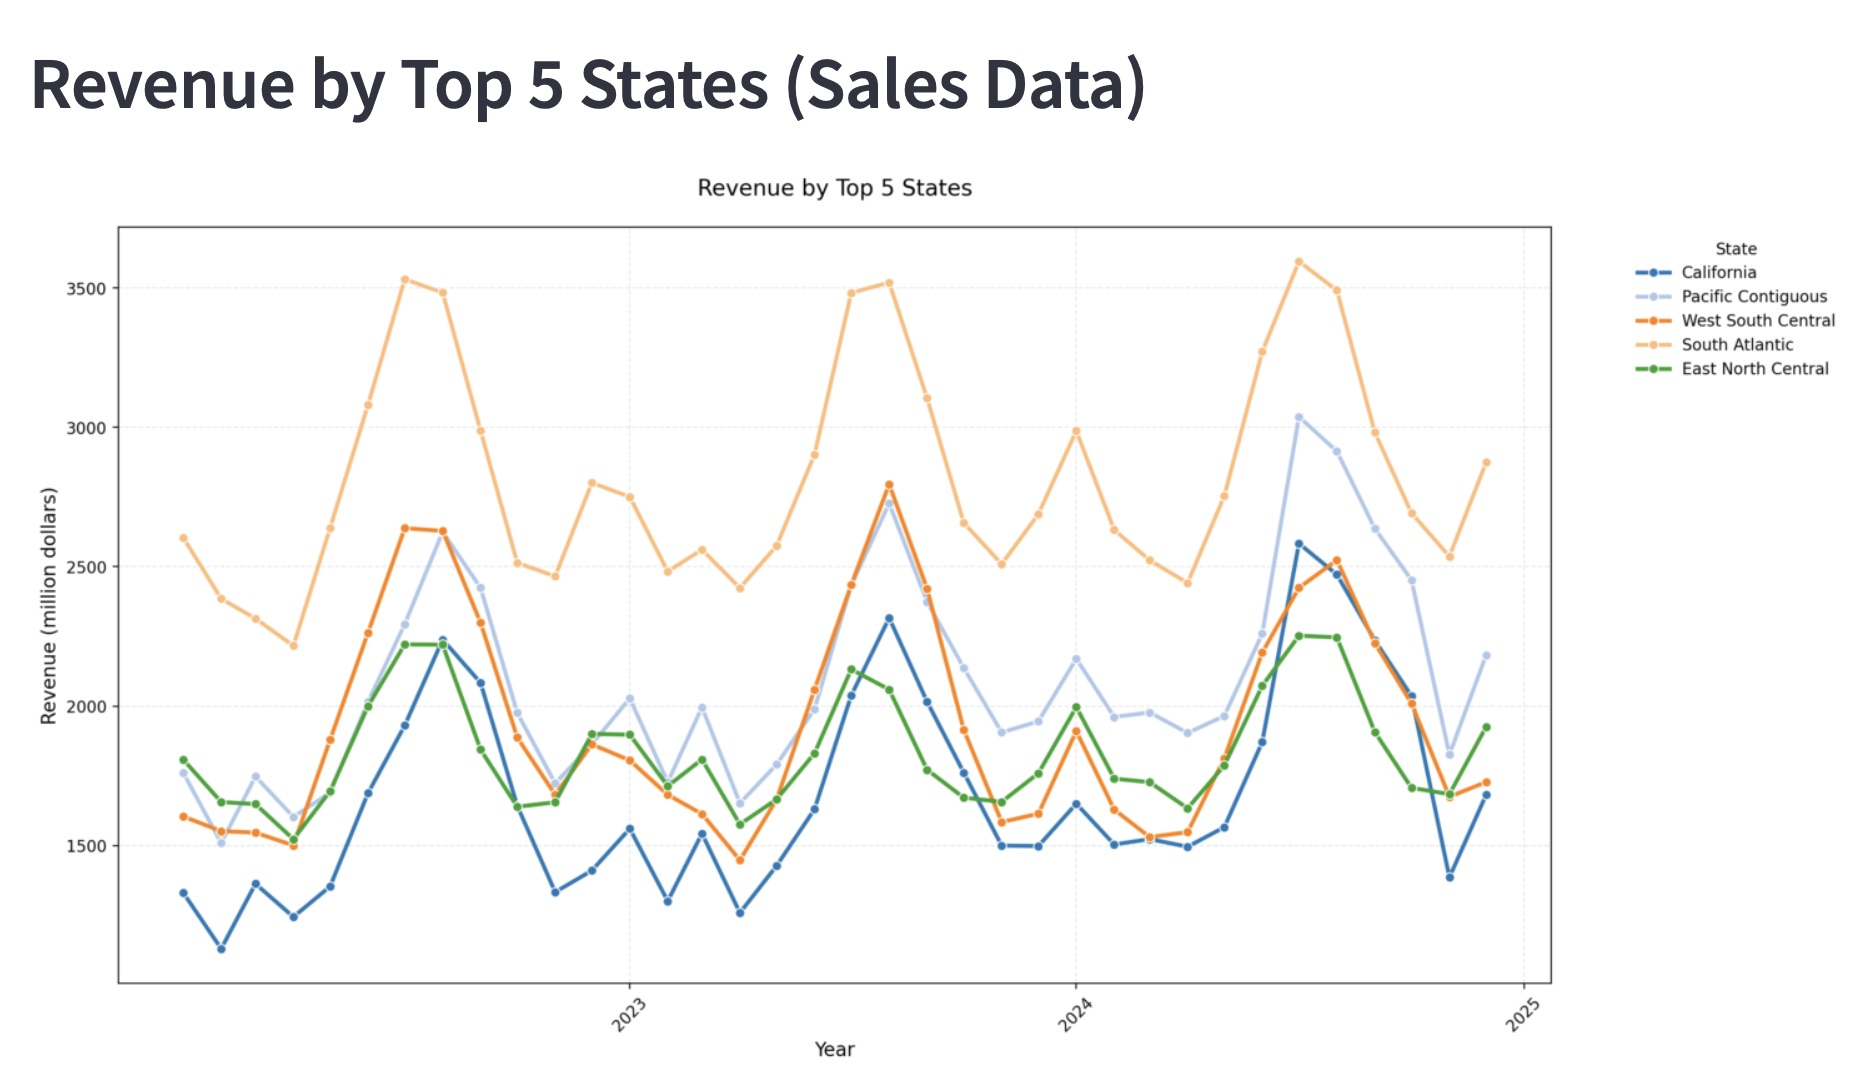

## 10. Challenges & Solutions

### 1. Large Dataset Handling
- The daily dataset included over **1.6 million rows**, making it difficult to open and process as a single file.
- Required partitioning by year and efficient S3 folder structure to support downstream tasks.
- CSV files were used instead of Parquet due to compatibility, despite the performance trade-off.

### 2. AWS Lambda Layer Size Limit
- Lambda functions have a **250 MB unzipped deployment package limit**, restricting the use of data processing libraries like PyArrow.
- Due to this, Parquet format couldn't be adopted, and the project continued with **CSV**.
- This impacted storage efficiency and read/write performance.

### 3. IAM Role & Permission Constraints
- Limited IAM access prevented the use of **high-memory EC2 instances** (e.g., >8GB RAM or multiple vCPUs).
- **Lambda-S3 event triggers** initially failed due to insufficient permissions.
- As a workaround, public access was temporarily enabled, posing potential **security risks**.

### 4. Streamlit Performance on Large Data
- Streamlit dashboards initially lagged when handling full-resolution datasets.
- Optimized by adding **pre-aggregation and caching** logic to improve load speed and interactivity.


## 11. Deployment & Automation

Our project leveraged both **manual and automated deployment techniques** to ingest, process, and serve electricity data across AWS services and local tools like Streamlit and Ngrok.

---

### Lambda Scheduling & Triggering

We automated periodic data ingestion using **AWS Lambda + EventBridge (CloudWatch Events)**.

- **Trigger Frequency**: Daily/Monthly
- **Service**: EventBridge rule calling a Lambda function for data transformation function to clean and write to DynamoDB


#### Example Workflow:

AWS Scheduler → Lambda Fetcher → S3 Bucket → EventBridge Trigger → Lambda Transformer → DynamoDB

> This ensured new data would be regularly pulled and available for visualization without manual effort.

---

### Streamlit App Deployment Options

The Streamlit application (`app.py`) was built and tested locally on an EC2 instance, and was exposed to the internet by opening port 8501.

#### Option A: Local
- Fastest way to share the dashboard
- Single command to launch public link
- Suitable for demos and development

```bash
streamlit run app.py

```
#### Option B: EC2 + Streamlit (Persistent)

- Can be hosted long-term using:
  - `nohup`
  - `systemd` (for service-based persistence)
  
- Optional: use `~/.streamlit/config.toml` to enable public access (e.g., setting `enableCORS = false` and defining port)

---

#### Option C: Streamlit Community Cloud *(Optional Future)*

- **Step 1**: Push project to a public GitHub repository  
- **Step 2**: Deploy via [streamlit.io/cloud](https://streamlit.io/cloud)  
- **Pros**:
  - Zero infrastructure
  - One-click deployment
  - Ideal for public demos

---

### Components in Production Flow

| **Component** | **Deployment Method**     | **Automation**                   |
|---------------|----------------------------|----------------------------------|
| **Lambda**    | Uploaded via console/ZIP   | Triggered by EventBridge         |
| **EC2**       | Manual provisioning        | Scheduled via cron (optional)    |
| **Streamlit** | Launched via EC2           | Can be automated with `nohup`    |
| **S3**        | Auto-updated via scripts   | Triggers downstream Lambdas      |
| **DynamoDB**  | Populated via Lambda       | Accessible instantly via dashboard |

---

> By integrating Lambda, S3, EC2, and Streamlit, we created a lightweight but powerful cloud-native pipeline that is both reproducible and scalable.


## 12. Future Improvements

While the current pipeline successfully integrates data ingestion, processing, forecasting, and visualization, several enhancements can significantly improve performance, scalability, and analytical depth.

---

### 1. Use of Parquet + AWS Glue Catalog

- **Current Limitation**: CSV files are large and not optimized for analytical queries.
- **Improvement**:
  - Store processed data in **Parquet** format to reduce file size and increase read performance.
  - Register tables using **AWS Glue Data Catalog** for seamless querying with Athena or Redshift Spectrum.

---

### 2. Enhanced ML Forecasting Models

- **Current Model**: Prophet (great for interpretability)
- **Future Alternatives**:  
  - **LSTM or GRU-based models** for long-sequence trend capture
  - **AutoML platforms** (SageMaker, H2O.ai) to experiment at scale

---

### 3. Real-Time Stream Processing (e.g., Kinesis)

- **Current Limitation**: Batch-mode ingestion via scheduled Lambda
- **Upgrade Path**:
  - Use **Amazon Kinesis Data Streams** for ingesting real-time energy grid events.
  - Combine with **Lambda** or **Kinesis Firehose** for near-real-time dashboard updates.

---

### 4. UI/UX Enhancements in Streamlit

- **Improvements**:
  - Add **date range pickers** and dynamic sliders for better filtering
  - Include **drilldown views** (state → city, fuel → plant)
  - Export forecast results to downloadable CSV
  - Add **streamlit-authenticator** for role-based access to views

---

### 5. CI/CD & Monitoring Tools

- Introduce **GitHub Actions** to automate:
  - Testing on code commit
  - Lambda packaging and deployment
  - S3 syncing of updated data

- Add **logging & monitoring**:
  - Use **AWS CloudWatch Logs** for Lambda observability
  - Set up **SNS alerts** for failed jobs or API downtime

---

> Implementing these future steps will elevate the current system into a production-ready data pipeline — scalable, maintainable, and insightful at every level.


## 13. Conclusion

Over the course of this project, we successfully built an end-to-end electricity forecasting pipeline using modern cloud and open-source tools.

---

### Key Achievements
- Automated **data ingestion** from the U.S. Energy Information Administration (EIA) API
- Performed **time series forecasting** using Facebook Prophet
- Designed and deployed a **Streamlit dashboard** for visualization and interactivity
- Incorporated **AWS services** (S3, Lambda, EC2) for scalable, serverless architecture

---

### Impact
- The system can help **utility providers, policymakers, and researchers** monitor trends and predict future energy demand and generation.
- The modular pipeline design ensures **reusability and future extensibility** for more complex analytics.

---

> **What We Learned:**  
This project deepened our understanding of cloud-native data pipelines, forecasting frameworks, and interactive dashboards. It demonstrated the importance of thoughtful architecture, reproducibility, and user-focused design.


## 14. Appendix


### 🔗 References & Resources

- [U.S. Energy Information Administration (EIA) API](https://www.eia.gov/opendata/)
- [Facebook Prophet Documentation](https://facebook.github.io/prophet/)
- [Streamlit Docs](https://docs.streamlit.io/)
- [AWS Official Docs](https://docs.aws.amazon.com/)


---

### 💻 Code & Repository

[GitHub Repository – EIA Data Pipeline]https://github.com/rgandhi-ucalgary/eia-data-pipeline)

---

> If you are replicating this project, remember to configure your AWS IAM roles and tokens properly and validate API changes from EIA over time.
